## Setup

In [1]:
!pip install -U transformers datasets accelerate bitsandbytes trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 31.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 20.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 22.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 33.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.0 M

In [2]:
import wandb
import os
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login, whoami

user_secrets = UserSecretsClient()

hf_token = user_secrets.get_secret("HF")
wandb_key = user_secrets.get_secret("wandb")

login(token=hf_token)
user_info = whoami()
print(f"Logged in as: {user_info['name']}")

os.environ["WANDB_API_KEY"] = wandb_key
wandb.login()

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Logged in as: grasgor


wandb: Currently logged in as: grasgor10 (grasgor10-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Weighted lambda DPO

### Model prep

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_from_disk, Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from tqdm import tqdm

model_name = "/kaggle/input/jobs-llama-set/transformers/default/1/llama3.2-jobs-sft-merged"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Load reference model (frozen)
ref_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map={"": torch.cuda.current_device()},
)
ref_model.eval()
ref_model.requires_grad_(False)

# Load model for PEFT (trainable policy)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map={"": torch.cuda.current_device()},
)
model.gradient_checkpointing_enable()

peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.0,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj"],
    bias="none",
    task_type="CAUSAL_LM",
)

peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()
peft_model.enable_input_require_grads()
peft_model.to(torch.cuda.current_device())

print("✅ PEFT model setup complete and ready for training!")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2025-10-27 12:33:00.752352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761568380.926226      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761568380.978105      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


trainable params: 3,801,088 || all params: 1,239,615,488 || trainable%: 0.3066
✅ PEFT model setup complete and ready for training!


In [40]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
import torch

model_name = "/kaggle/input/jobs-llama-set/transformers/default/1/llama3.2-jobs-sft-merged"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map={"": torch.cuda.current_device()},
)

model.gradient_checkpointing_enable()

peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.0,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj"],
    bias="none",
    task_type="CAUSAL_LM",
)


In [41]:
num_lora_layers = sum(1 for name, _ in model.named_parameters() if "lora_" in name)
print(f"Total LoRA layers: {num_lora_layers}")

Total LoRA layers: 0


In [42]:
for n, p in model.named_parameters():
        print(n)

model.embed_tokens.weight
model.layers.0.self_attn.q_proj.weight
model.layers.0.self_attn.k_proj.weight
model.layers.0.self_attn.v_proj.weight
model.layers.0.self_attn.o_proj.weight
model.layers.0.mlp.gate_proj.weight
model.layers.0.mlp.up_proj.weight
model.layers.0.mlp.down_proj.weight
model.layers.0.input_layernorm.weight
model.layers.0.post_attention_layernorm.weight
model.layers.1.self_attn.q_proj.weight
model.layers.1.self_attn.k_proj.weight
model.layers.1.self_attn.v_proj.weight
model.layers.1.self_attn.o_proj.weight
model.layers.1.mlp.gate_proj.weight
model.layers.1.mlp.up_proj.weight
model.layers.1.mlp.down_proj.weight
model.layers.1.input_layernorm.weight
model.layers.1.post_attention_layernorm.weight
model.layers.2.self_attn.q_proj.weight
model.layers.2.self_attn.k_proj.weight
model.layers.2.self_attn.v_proj.weight
model.layers.2.self_attn.o_proj.weight
model.layers.2.mlp.gate_proj.weight
model.layers.2.mlp.up_proj.weight
model.layers.2.mlp.down_proj.weight
model.layers.2.inp

In [43]:
from peft import get_peft_model
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()
peft_model.enable_input_require_grads()
peft_model.to(torch.cuda.current_device())
print("✅ PEFT model setup complete and ready for training!")

trainable params: 3,801,088 || all params: 1,239,615,488 || trainable%: 0.3066
✅ PEFT model setup complete and ready for training!


In [44]:
num_lora_layers_peft = sum(1 for name, _ in peft_model.named_parameters() if "lora_" in name)
print(f"Total LoRA layers: {num_lora_layers_peft}")

Total LoRA layers: 160


In [45]:
for n, p in peft_model.named_parameters():
    print(n)

base_model.model.model.embed_tokens.weight
base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight
base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight
base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight
base_model.model.model.layers.0.self_attn.o_proj.weight
base_model.model.model.layers.0.mlp.gate_proj.weight
base_model.model.model.layers.0.mlp.up_proj.base_layer.weight
base_model.model.model.layers.0.mlp.up_proj.lora_A.default.weight
base_model.model.model.layers.0.mlp.up_proj.lora_B.default.weight
base_model.model.model.laye

### Dataset prep

In [5]:
from datasets import load_from_disk, Dataset, DatasetDict

ds = load_from_disk("/kaggle/input/dpo-dataset/dpo_dataset_checkpoint")  # user-provided arrow dataset
# Expect columns: prompt, completion, rejected_1, rejected_2, rejected_3
# Convert to simple list of dicts
records = []
for row in ds:
    rec = {
        "prompt": row["prompt"],
        "chosen": row.get("completion"),
        "rejected_1": row.get("rejected_1"),
        "rejected_2": row.get("rejected_2"),
        "rejected_3": row.get("rejected_3"),
        "rejected": [row.get("rejected_1"), row.get("rejected_2"), row.get("rejected_3"),]
    }
    records.append(rec)
print(f"Loaded {len(records)} examples.")

Loaded 427 examples.


In [6]:
records[0]

{'prompt': 'How about some concrete reasons to buy a computer today? An executive in your industry recently said, “We’ve given people computers, but we haven’t shown them what to do with them. I can balance my checkbook faster by hand than on my computer.” Why should a person buy a computer?',
 'chosen': 'There are different answers for different people. In business, that question is easy to answer: You really can prepare documents much faster and at a higher quality level, and you can do many things to increase office productivity. A computer frees people from much of the menial work. Besides that, you are giving them a tool that encourages them to be creative. Remember, computers are tools. Tools help us do our work better. In education, computers are the first thing to come along since books that will sit there and interact with you endlessly, without judgment. Socratic education isn’t available anymore, and computers have the potential to be a real breakthrough in the educational p

In [7]:
import numpy as np
from tqdm import tqdm
from pathlib import Path
import torch.nn.functional as F

EMB_CACHE_DIR = "./emb_cache"
BATCH_EMB = 4
MAX_EMB_TOKENS = 3072
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs(EMB_CACHE_DIR, exist_ok=True)

def batch_texts(records, key_fn, batch_size=BATCH_EMB):
    for i in range(0, len(records), batch_size):
        batch = records[i:i+batch_size]
        texts = [key_fn(r) for r in batch]
        yield i, batch, texts

@torch.no_grad()
def embed_texts_batched(model, tokenizer, texts, max_length=MAX_EMB_TOKENS):
    # returns tensor (len(texts), dim)
    toks = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(DEVICE)
    outputs = model.model(**toks, output_hidden_states=True)
    hidden = outputs.hidden_states[-2]  # second-to-last
    mask = toks["attention_mask"].unsqueeze(-1)
    emb = (hidden * mask).sum(dim=1) / mask.sum(dim=1)
    emb = F.normalize(emb, dim=-1)
    return emb.cpu()

# Check cache, compute if missing
print("Computing/caching embeddings (chosen + 3 rejects) ...")
for idx in tqdm(range(len(records)), desc="examples"):
    cfile = Path(EMB_CACHE_DIR) / f"emb_chosen_{idx}.npy"
    rfiles = [Path(EMB_CACHE_DIR) / f"emb_rej{j+1}_{idx}.npy" for j in range(3)]
    if cfile.exists() and all(rf.exists() for rf in rfiles):
        continue  # cached

    # build small micro-batch for this example
    texts = [records[idx]["chosen"]] + records[idx]["rejected"]
    # embed all at once to reduce overhead
    emb = embed_texts_batched(ref_model, tokenizer, texts, max_length=MAX_EMB_TOKENS)  # shape (4, dim)
    np.save(cfile, emb[0].numpy())
    for j in range(3):
        np.save(rfiles[j], emb[j+1].numpy())

print("Embedding cache ready.")

Computing/caching embeddings (chosen + 3 rejects) ...


examples: 100%|██████████| 427/427 [02:20<00:00,  3.04it/s]

Embedding cache ready.


Loading embeddings: 100%|██████████| 427/427 [00:00<00:00, 2230.45it/s]


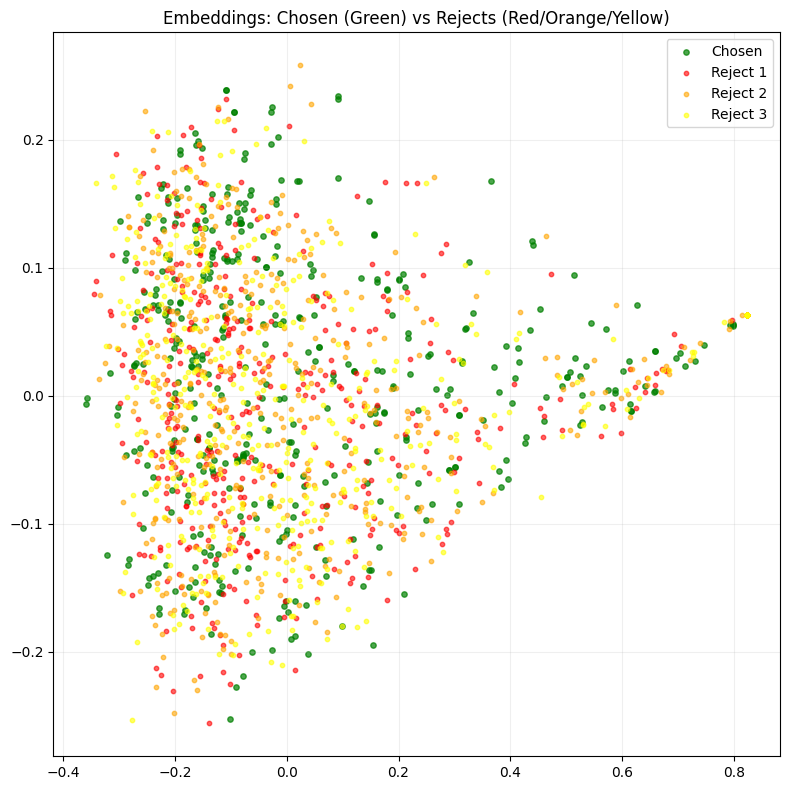

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA
from tqdm import tqdm

# --- Config ---
EMB_CACHE_DIR = "./emb_cache"
NUM_EXAMPLES = 427  # adjust if needed
reject_colors = ["red", "orange", "yellow"]
chosen_color = "green"

chosen_embs, reject_embs = [], []

# --- Load all cached embeddings ---
for idx in tqdm(range(NUM_EXAMPLES), desc="Loading embeddings"):
    cfile = Path(EMB_CACHE_DIR) / f"emb_chosen_{idx}.npy"
    rfiles = [Path(EMB_CACHE_DIR) / f"emb_rej{j+1}_{idx}.npy" for j in range(3)]
    if not cfile.exists() or not all(r.exists() for r in rfiles):
        continue
    c = np.load(cfile)
    rs = [np.load(r) for r in rfiles]
    chosen_embs.append(c)
    reject_embs.append(rs)

# Stack into arrays
chosen_embs = np.stack(chosen_embs)  # (N, dim)
reject_embs = np.stack(reject_embs)  # (N, 3, dim)
reject_embs_flat = reject_embs.reshape(-1, reject_embs.shape[-1])  # (N*3, dim)

# Combine all for PCA
all_embs = np.concatenate([chosen_embs, reject_embs_flat], axis=0)
pca = PCA(n_components=2)
reduced = pca.fit_transform(all_embs)

# Split back
n_chosen = len(chosen_embs)
chosen_2d = reduced[:n_chosen]
reject_2d = reduced[n_chosen:].reshape(-1, 3, 2)

# --- Plot ---
plt.figure(figsize=(8, 8))
plt.scatter(
    chosen_2d[:, 0],
    chosen_2d[:, 1],
    color=chosen_color,
    s=15,
    alpha=0.7,
    label="Chosen"
)

for j in range(3):
    plt.scatter(
        reject_2d[:, j, 0],
        reject_2d[:, j, 1],
        color=reject_colors[j],
        s=10,
        alpha=0.6,
        label=f"Reject {j+1}"
    )

plt.title("Embeddings: Chosen (Green) vs Rejects (Red/Orange/Yellow)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


In [ ]:
TEMP = 0.2

def load_emb(path):
    return torch.from_numpy(np.load(path)).to(DEVICE)

lambda_list = []
for idx in tqdm(range(len(records)), desc="compute-lambdas"):
    cfile = Path(EMB_CACHE_DIR) / f"emb_chosen_{idx}.npy"
    rfiles = [Path(EMB_CACHE_DIR) / f"emb_rej{j+1}_{idx}.npy" for j in range(3)]
    emb_ch = load_emb(cfile)   # (D,)
    emb_rejs = torch.stack([load_emb(p) for p in rfiles], dim=0)  # (3, D)
    # cosine: emb_ch (D,) @ emb_rejs.T -> (3,)
    cos = torch.matmul(emb_rejs, emb_ch)   # (3,)  (emb_rejs @ emb_ch) because both normalized
    lambdas = F.softmax(cos / TEMP, dim=-1).cpu().numpy().tolist()
    lambda_list.append(lambdas)

# attach lambdas to records
for r, lam in zip(records, lambda_list):
    r["lambda_weights"] = lam

print("Computed lambdas for all examples (first 3):", lambda_list[:3])

compute-lambdas: 100%|██████████| 427/427 [00:00<00:00, 986.40it/s] 

Computed lambdas for all examples (first 3): [[0.08587646484375, 0.45703125, 0.45703125], [0.333251953125, 0.309326171875, 0.357421875], [0.317626953125, 0.35986328125, 0.322509765625]]


In [ ]:
def preprocess(records, lambda_list):
    processed = []
    for r, lambdas in zip(records, lambda_list):
        prompt = r["prompt"]
        chosen = r["chosen"]
        rejects = [r["rejected_1"], r["rejected_2"], r["rejected_3"]]

        processed.append({
            "prompt": prompt,
            "chosen_text": prompt + chosen,
            "reject_texts": [prompt + rej for rej in rejects],
            "lambdas": torch.tensor(lambdas, dtype=torch.float32),
        })
    return processed


class MultiRejectDPODataset(Dataset):
    def __init__(self, processed_records):
        self.records = processed_records

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        return self.records[idx]

def collate_fn(batch):
    chosens = [b["chosen_text"] for b in batch]
    rejects = [b["reject_texts"] for b in batch]
    lambdas = torch.stack([b["lambdas"] for b in batch])

    tokenized = tokenizer(
        chosens + sum(rejects, []),
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    batch_size = len(chosens)
    chosen_input = {k: v[:batch_size] for k, v in tokenized.items()}
    reject_input = {
        k: v[batch_size:].view(batch_size, 3, -1) for k, v in tokenized.items()
    }

    return {
        "chosen": chosen_input,
        "reject": reject_input,
        "lambdas": lambdas,
    }

processed_records = preprocess(records, lambda_list)
dataset = MultiRejectDPODataset(processed_records)
train_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [12]:
dataset[0]

{'prompt': 'How about some concrete reasons to buy a computer today? An executive in your industry recently said, “We’ve given people computers, but we haven’t shown them what to do with them. I can balance my checkbook faster by hand than on my computer.” Why should a person buy a computer?',
 'chosen_text': 'How about some concrete reasons to buy a computer today? An executive in your industry recently said, “We’ve given people computers, but we haven’t shown them what to do with them. I can balance my checkbook faster by hand than on my computer.” Why should a person buy a computer?There are different answers for different people. In business, that question is easy to answer: You really can prepare documents much faster and at a higher quality level, and you can do many things to increase office productivity. A computer frees people from much of the menial work. Besides that, you are giving them a tool that encourages them to be creative. Remember, computers are tools. Tools help us

### Training

In [ ]:
import torch.nn.functional as F

def compute_logp(model, input_ids, attention_mask):
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    log_probs = F.log_softmax(outputs.logits, dim=-1)
    shift_input_ids = input_ids[:, 1:]
    shift_log_probs = log_probs[:, :-1, :]
    token_logp = shift_log_probs.gather(2, shift_input_ids.unsqueeze(-1)).squeeze(-1)
    seq_logp = (token_logp * attention_mask[:, 1:]).sum(dim=1)
    return seq_logp


def multi_reject_dpo_loss(policy_model, ref_model, batch, beta=0.1):
    chosen_ids = batch["chosen"]["input_ids"].to(device)
    chosen_mask = batch["chosen"]["attention_mask"].to(device)
    reject_ids = batch["reject"]["input_ids"].to(device)
    reject_mask = batch["reject"]["attention_mask"].to(device)
    lambdas = batch["lambdas"].to(device)  # (batch, 3)

    # Log-probabilities
    logp_chosen_policy = compute_logp(policy_model, chosen_ids, chosen_mask)
    logp_chosen_ref    = compute_logp(ref_model, chosen_ids, chosen_mask)
    logp_reject_policy = torch.stack(
        [compute_logp(policy_model, reject_ids[:, i, :], reject_mask[:, i, :]) for i in range(3)],
        dim=1
    )
    logp_reject_ref = torch.stack(
        [compute_logp(ref_model, reject_ids[:, i, :], reject_mask[:, i, :]) for i in range(3)],
        dim=1
    )

    # Weighted average per example
    avg_reject_policy = (lambdas * logp_reject_policy).sum(dim=1)
    avg_reject_ref    = (lambdas * logp_reject_ref).sum(dim=1)

    delta = (logp_chosen_policy - logp_chosen_ref) - (avg_reject_policy - avg_reject_ref)
    loss = -torch.log(torch.sigmoid(beta * delta))
    return loss.mean()


import wandb
from tqdm import tqdm

# Initialize Weights & Biases run
wandb.init(
    project="multi-reject-dpo",
    name="llama3.2-lora-dpo",
    config={
        "learning_rate": 1e-5,
        "beta": 0.1,
        "epochs": 1,
        "batch_size": train_loader.batch_size,
        "model": "llama3.2 + LoRA",
        "dpo_variant": "averaged_multi_reject",
    },
)

# Freeze all except LoRA
for name, param in peft_model.named_parameters():
    param.requires_grad = ("lora_" in name)

optimizer = torch.optim.AdamW(
    [p for p in peft_model.parameters() if p.requires_grad],
    lr=1e-5,
)

num_epochs = 1
beta = 0.1

peft_model.train()
global_step = 0
for epoch in range(num_epochs):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in pbar:
        optimizer.zero_grad()
        loss = multi_reject_dpo_loss(peft_model, ref_model, batch, beta=beta)
        loss.backward()
        optimizer.step()

        global_step += 1
        wandb.log({
            "train/loss": loss.item(),
            "train/epoch": epoch,
            "train/step": global_step,
            "train/lr": optimizer.param_groups[0]["lr"],
        })

        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    # optional: checkpoint or evaluation hooks per epoch
    torch.cuda.empty_cache()

print("Training complete with multi-reject DPO (LoRA policy vs frozen ref model)")

wandb.finish()


Epoch 1: 100%|██████████| 214/214 [15:56<00:00,  4.47s/it, loss=0.0897]

✅ Training complete with multi-reject DPO (LoRA policy vs frozen ref model)


train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,▇▇▆▆▆▄▄▂▅▃▁▂▆▃▆▃▃▃▁▁▂▁▂▁▄▂▂▁▁█▃▂▂▂▂▁▁▁▂▁
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/step,▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇██
train/epoch,0
train/loss,0.08967
train/lr,1e-05
train/step,214


In [ ]:
SAVE_SAFE_DIR = "./llama3.2_jobs_dpo_custom"
os.makedirs(SAVE_SAFE_DIR, exist_ok=True)
all_finite = True
for n, p in peft_model.named_parameters():
    if p.requires_grad and (torch.isnan(p).any() or torch.isinf(p).any()):
        print(f"Cannot save: parameter {n} contains NaN/Inf")
        all_finite = False
        break

if all_finite:
    save_dir = SAVE_SAFE_DIR
    os.makedirs(save_dir, exist_ok=True)
    peft_model.save_pretrained(save_dir)
    print(f"✅ DPO fine-tuned adapters saved at {save_dir}")
else:
    print("Adapters not saved because model contains NaNs/Infs. You can restore last_safe_snapshot manually if needed.")


✅ DPO fine-tuned adapters saved at ./llama3.2_jobs_dpo_custom


## Save Merged Model

In [20]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load base model in FP16 (recommended for merging)
base_model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto",
    torch_dtype="auto"
)

# Load your SFT-trained LoRA adapter
model = PeftModel.from_pretrained(model, "/kaggle/working/llama3.2_jobs_dpo_custom")

# Merge LoRA weights into base model
model = model.merge_and_unload()

# Save merged model and tokenizer
save_dir = "./llama3.2-jobs-dpo-custom-merged"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

('./llama3.2-jobs-dpo-custom-merged/tokenizer_config.json',
 './llama3.2-jobs-dpo-custom-merged/special_tokens_map.json',
 './llama3.2-jobs-dpo-custom-merged/tokenizer.json')

## DPO Model Inference

In [19]:
from transformers import pipeline

pipe = pipeline("text-generation", model="/kaggle/working/llama3.2_jobs_dpo_custom", tokenizer=tokenizer, return_full_text=False)

prompt = "Is there an inevitable break between being an entrepreneur and a businessman? Are the people who get things going different?"

result = pipe(
    prompt,
    max_new_tokens=3072,
    temperature=0.8,
    do_sample=True,
    top_k=50,                  
    top_p=0.9,                 
    repetition_penalty=1.2     
)
print(result[0]["generated_text"])


Device set to use cuda:0


I think they are. I was in that business, though; I ran my own companies for about 10 years after university. In some ways, it is more difficult to be an entrepreneur than a manager. You have to take on all of these responsibilities as well: marketing, finance, operations--you know, everything. And you also need to learn how to run large organizations. All those skills just didn't exist at Harvard Business School. So I had to go out and do both.


In [21]:
prompt = "How about some concrete reasons to buy a computer today? An executive in your industry recently said, “We’ve given people computers, but we haven’t shown them what to do with them. I can balance my checkbook faster by hand than on my computer.” Why should a person buy a computer?"

result = pipe(
    prompt,
    max_new_tokens=3072,
    temperature=0.8,
    do_sample=True,
    top_k=50,                  
    top_p=0.9,                 
    repetition_penalty=1.2     
)
print(result[0]["generated_text"])

It’s the only tool that has the ability and power of IBM 360s, Apple IIIs, Macintoshes combined. It lets you take an idea from conception to production. And it is fun. You have to use one for that.
